# Description
For each density bin, plot the measured multipoles as well as the fitted Kaiser model with and without a FoG term.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, erf
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [10]:
# load data multipoles
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034 and ignore first k bin
possible_kmax = k_full[k_full<=0.343][1:]
# set kmax up to which parameters have been fitted and slice data quantaties
kmax = possible_kmax[11] 
mask = np.full(len(k_full), False)
mask = k_full <= kmax
mask[0] = False 
k = k_full[mask]
Pk_ells = Pk_ells_full[:,:,mask]

# load fitted parameter values
b1 = np.loadtxt("fit_results/NoFoG/b1_fits.txt")
beta = np.loadtxt("fit_results/NoFoG/beta_fits.txt")

b1_damped = np.loadtxt("fit_results/FoG/b1_fits.txt")
beta_damped = np.loadtxt("fit_results/FoG/beta_fits.txt")
sigma_damped = np.loadtxt("fit_results/FoG/sigma_fits.txt")

In [5]:
def Kaiser(theta):
    '''Analytic expression for monopole and quadrupole for pure Kaiser model'''
    b1, beta = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
    
    return model_multipoles
    

def Kaiser_damped(theta):
    '''Analytic expression for monopole and quadrupole for Kaiser model damped by Gaussian FoG'''
    b1, beta, sigma = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    
    return model_multipoles

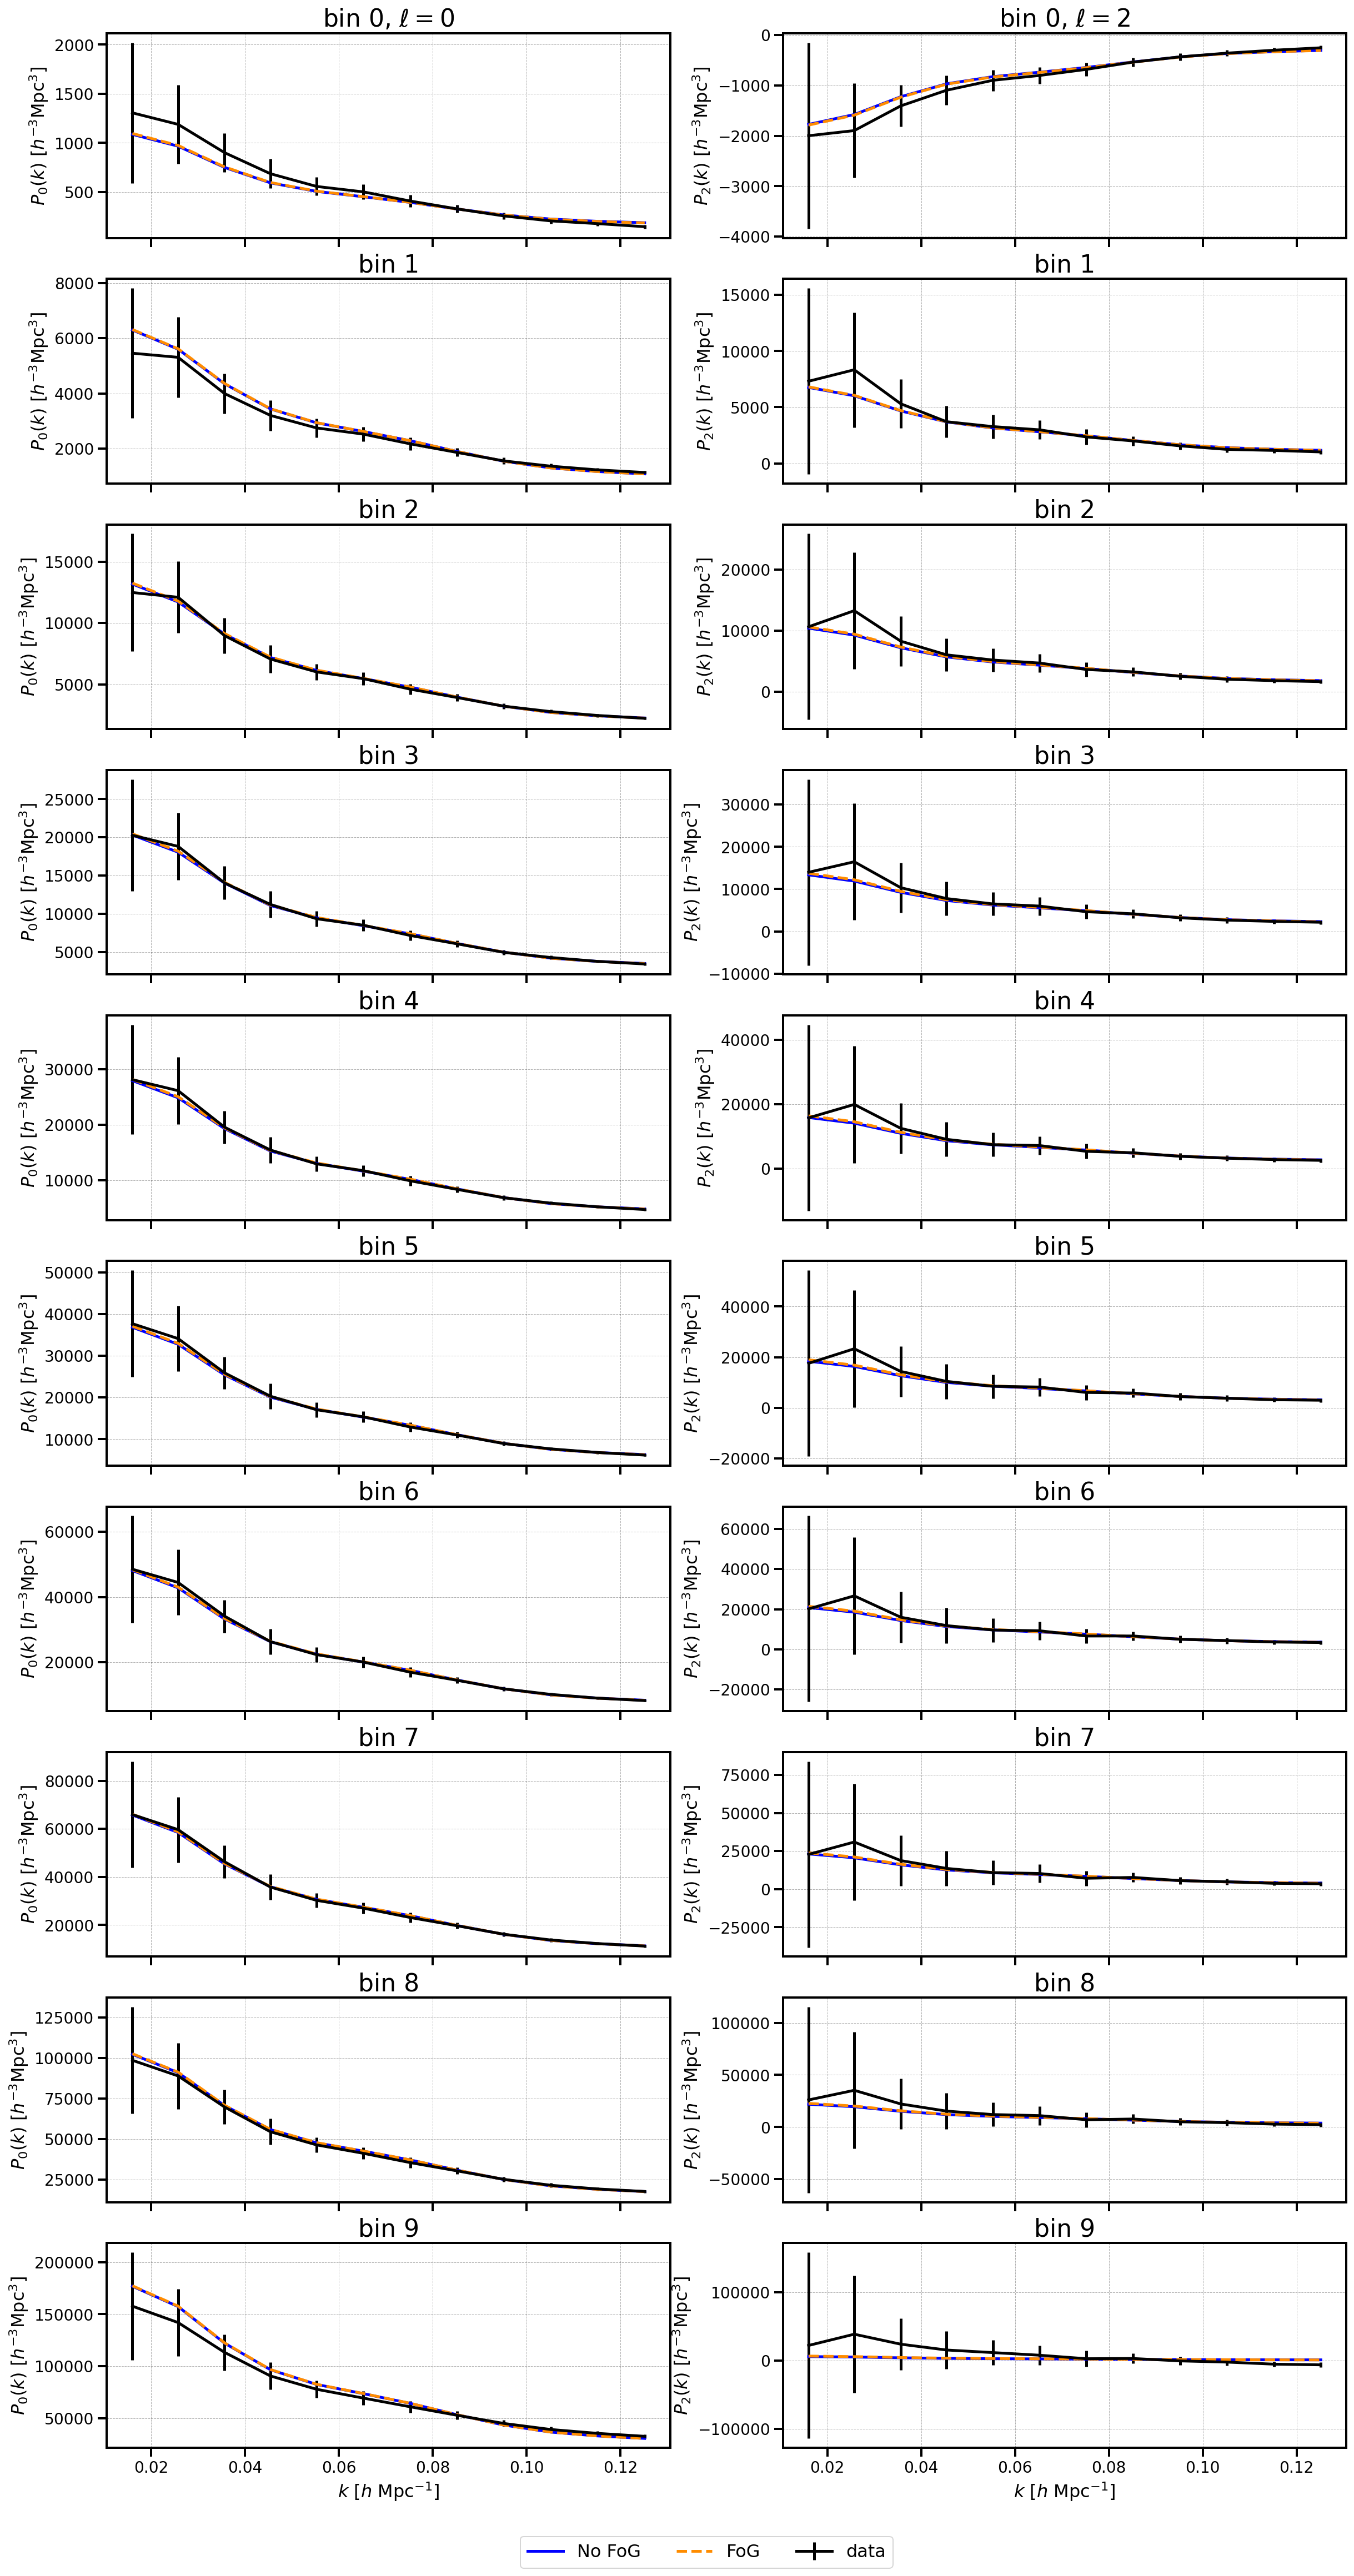

In [37]:
# plot data (with errors) and best fit Kaiser and damped Kaiser
fig, axs = plt.subplots(n_ptile, 2, figsize=(20,40), sharex=True) 

for i in range(n_ptile):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    kaiser_damped_sig = np.full((len(k), len(sigma_vals), 2), np.nan)
    for s, sigma in enumerate(sigma_vals):
        theta_damped_sig = [theta_damped[0], theta_damped[1], sigma] 
        kaiser_damped_sig[:,s,0], kaiser_damped_sig[:,s,1] = Kaiser_damped(theta_damped_sig) 
    
    # get diagonals of inverse covarinace matrix as errors on data
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    cov_mat_sliced = icf.slice_covmat(cov_mat, k_full, kmax)
    errs = np.sqrt(np.diagonal(cov_mat_sliced).reshape((2,-1)))
    
    for l, ell in enumerate(ells):
        if i == 0:
            axs[i][l].set_title(r'bin %d, $\ell=%d$'%(i,ell))
        else:
            axs[i][l].set_title(r'bin %d'%i)

        axs[i][l].errorbar(k, Pk_ells[i][l], yerr=errs[l] ,c='k', label='data')
        axs[i][l].plot(k, kaiser[l], c='blue',label='No FoG')
        axs[i][l].plot(k, kaiser_damped[l], linestyle='--', c='darkorange', label='FoG')
        
        if i == 9:
            axs[i][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[i][l].set_ylabel(r'$P_{%d}(k)$ [$h^{-3}\mathrm{Mpc}^3$]'%ell)
        
    
    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, +0.1), ncol=n_ptile)

plt.show()
#fig.savefig('plots/data_fittedmodels.pdf')

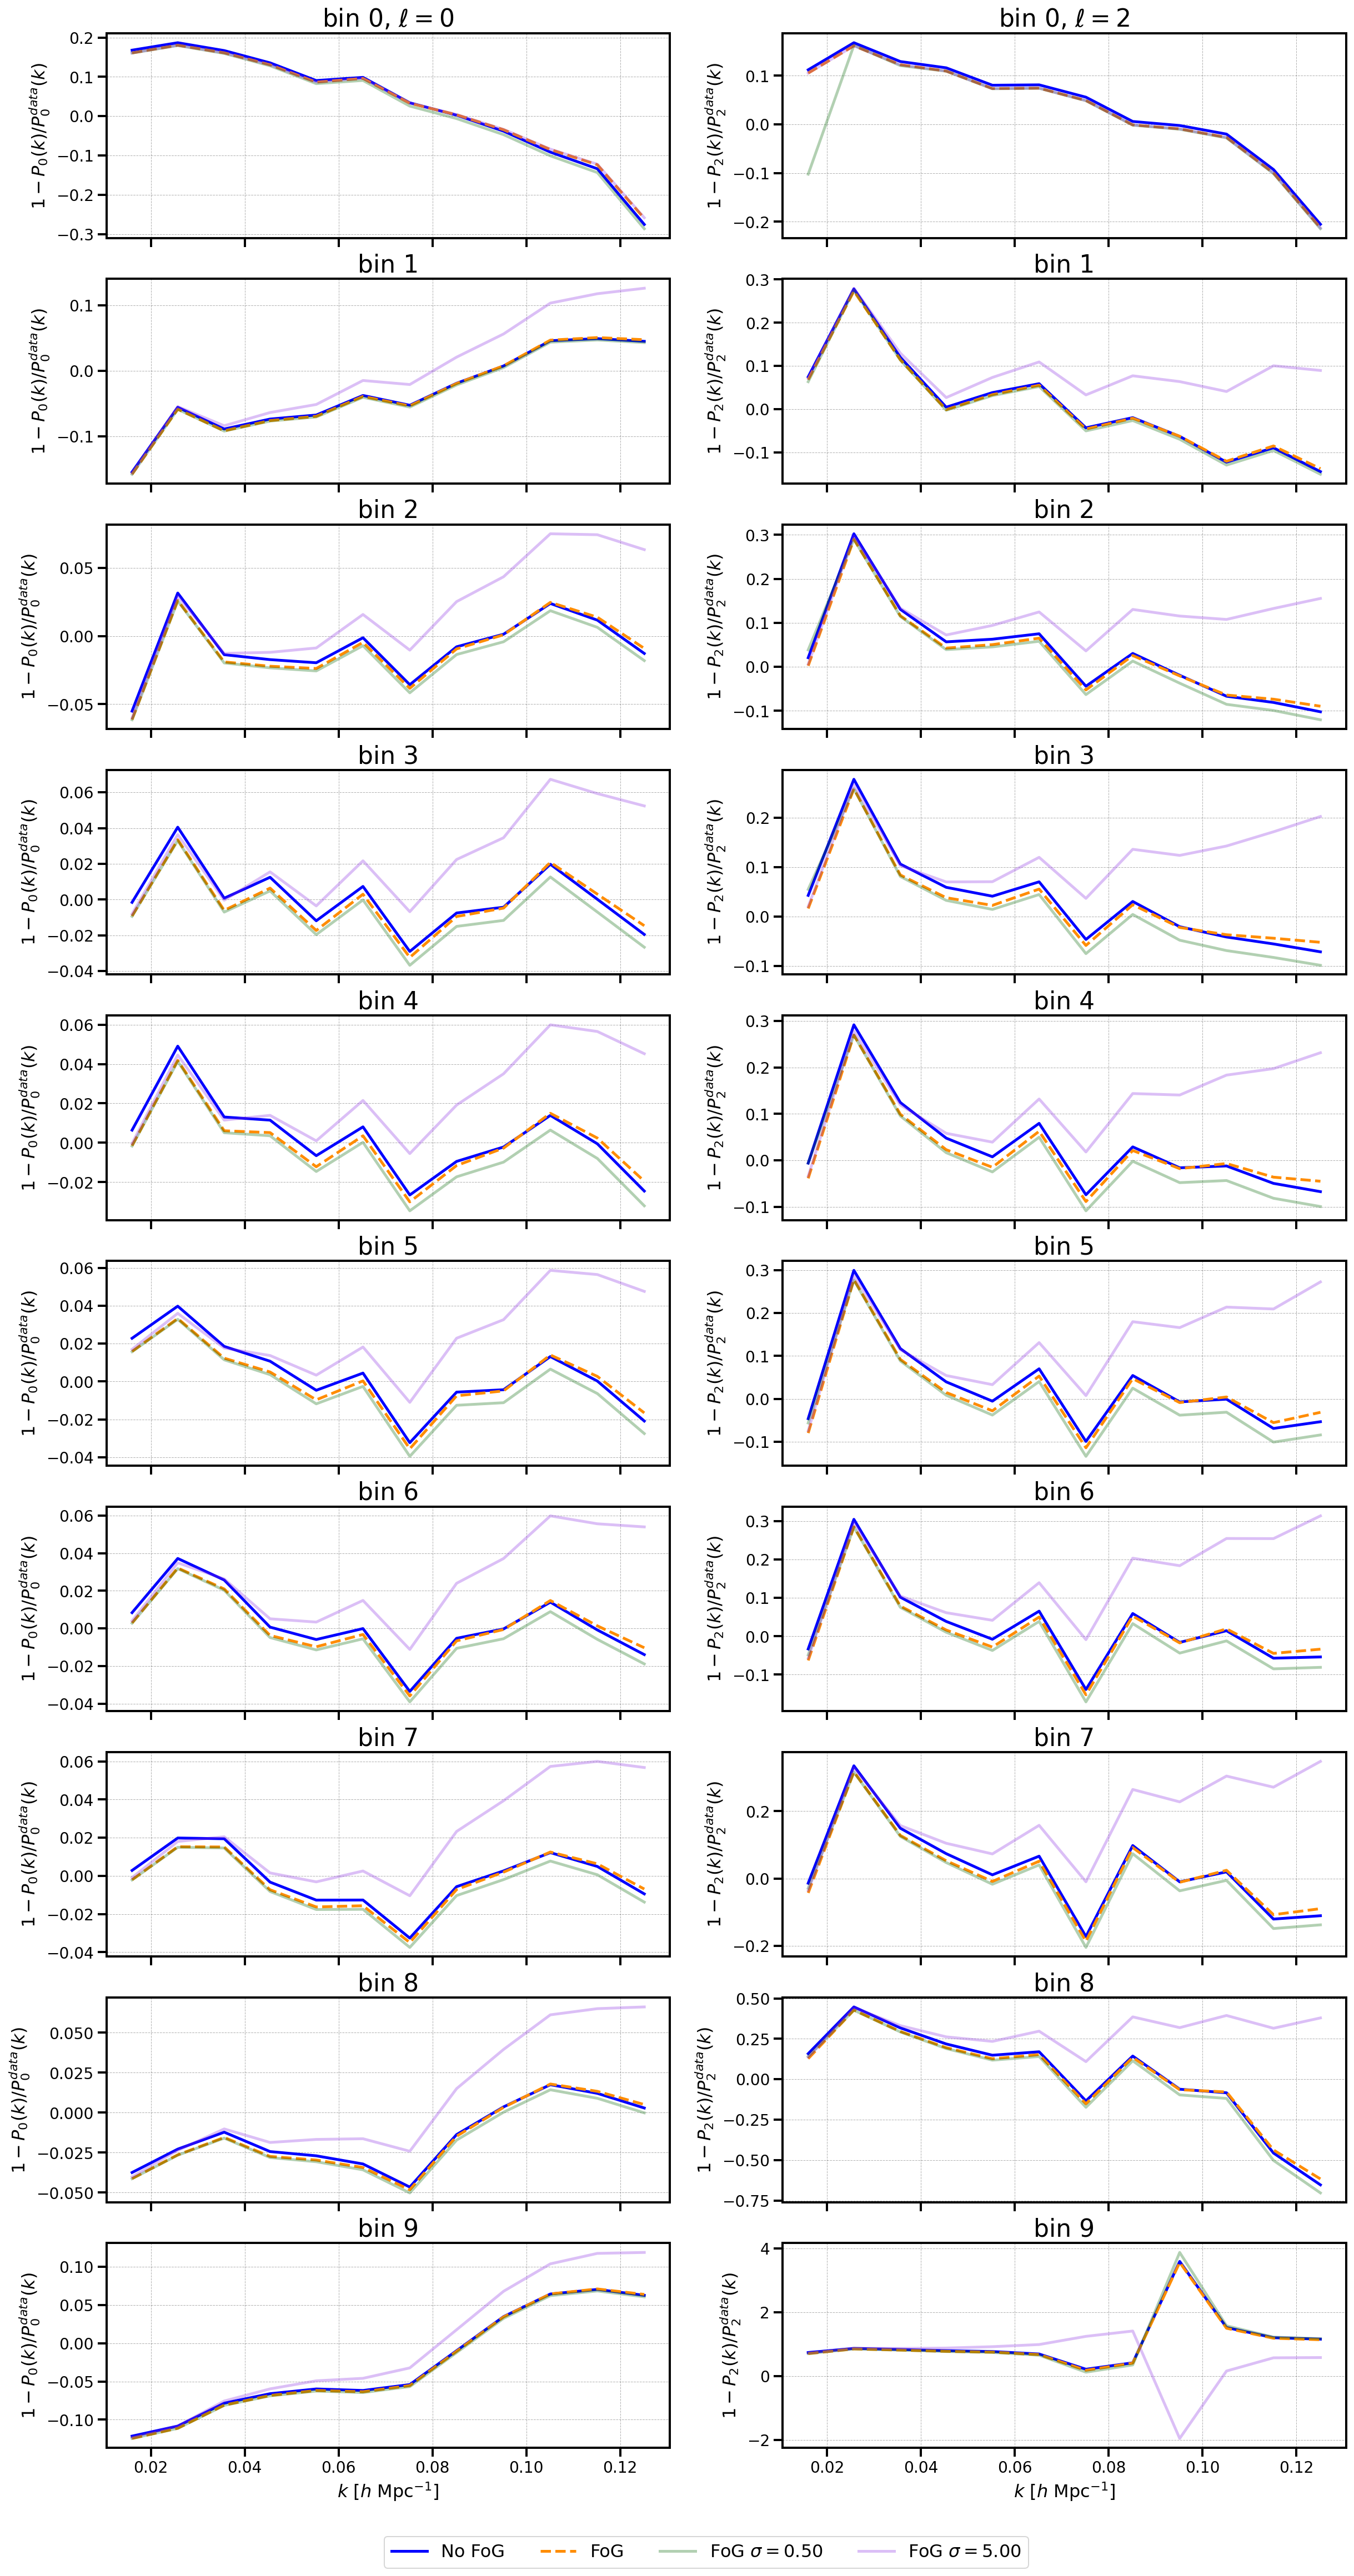

In [38]:
# plot relative error between data and models. To gauge range of sigma also add modle prediction at manually choosen sigma
sigma_vals = [0.5, 5]
sigma_cs = ['darkgreen', 'blueviolet']

fig, axs = plt.subplots(n_ptile, 2, figsize=(20,40), sharex=True) 

for i in range(n_ptile):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    kaiser_damped_sig = np.full((len(k), len(sigma_vals), 2), np.nan)
    for s, sigma in enumerate(sigma_vals):
        theta_damped_sig = [theta_damped[0], theta_damped[1], sigma] 
        kaiser_damped_sig[:,s,0], kaiser_damped_sig[:,s,1] = Kaiser_damped(theta_damped_sig) 
    
    for l, ell in enumerate(ells):
        if i == 0:
            axs[i][l].set_title(r'bin %d, $\ell=%d$'%(i,ell))
        else:
            axs[i][l].set_title(r'bin %d'%i)

        axs[i][l].plot(k, 1-kaiser[l]/Pk_ells[i][l], c='blue',label='No FoG')
        axs[i][l].plot(k, 1-kaiser_damped[l]/Pk_ells[i][l], linestyle='--', c='darkorange', label='FoG')
        for s, sig in enumerate(sigma_vals): 
            axs[i][l].plot(k, 1-kaiser_damped_sig[:,s,l]/Pk_ells[i][l], c=sigma_cs[s], alpha=0.3, label=r'FoG $\sigma=%.2f$'%sig)
        
        if i == 9:
            axs[i][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[i][l].set_ylabel(r'$1-P_{%d}(k)/P_{%d}^{data}(k)$'%(ell,ell))
        
    
    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, +0.1), ncol=n_ptile)

plt.show()
#fig.savefig('plots/data_fittedmodels_relerr.pdf')

### Interpretation
Not a large improvement by including FoG term. Positive values indicate too much damping while negative ones indicate too little. Generally, monopole agreement (percent level) much better than quadrupole (10s of percent).